In [1]:
#|default_exp augment

# Augmentation

In [2]:
#|export
import torch
import random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import * 
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [3]:
import torch.nn.functional as F
from functools import partial
import matplotlib.pyplot as plt
from torch import tensor, optim
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset
from fastcore.test import test_close
import torchvision.transforms.functional as TF

import logging; logging.disable(logging.WARNING)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
plt.style.use('fast')


In [4]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
bs = 1024
xmean, xstd = 0.29, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o) - xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
set_seed(42)

In [6]:
def get_model(act=GeneralReLU, nfs=(16, 32, 64, 128, 256, 512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]

    return nn.Sequential(*layers)

In [10]:
lr, epochs = 1e-2, 5
tmax = epochs * len(dls.train)
sched = partial(optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

lr_find_cbs = [DeviceCB()]
cbs = [DeviceCB(), metrics, astats, ProgressCB(plot=True), BatchSchedCB(sched)]
learn = Learner(get_model(act_gr).apply(iw), dls, F.cross_entropy, lr=lr, cbs=lr_find_cbs, opt_func=optim.AdamW)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit(epochs, lr=1e-2, cbs=cbs)

## Pooling

In [12]:
class GlobalAvgPool(nn.Module):
    def forward(self, x): return x.mean((-2, -1))

In [19]:
def get_model2(act=partial(GeneralReLU, leak=0.1, sub=0.4), nfs=(16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs) -1)]
    layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(512, 10, bias=True), nn.BatchNorm1d(10), nn.Softmax(dim=1)]
    return nn.Sequential(*layers)

In [1]:
#| export
def _flops(x, h, w):
    if x.dim() <= 3: return x.numel()
    if x.dim() == 4: return x.numel()*h*w

@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFlops|\n|--|--|--|--|--|\n'
    totp, totf = 0, 0
    @hook
    def _f(hook, model, inp, out):
        nonlocal res, totp, totf
        num_params = sum(o.numel() for o in model.parameters())
        totp += num_params
        *_, h, w = out.shape
        flops = sum(_flops(o, h, w) for o in model.parameters())/1e6
        totf += flops
        res += f'|{type(model).__name__}|{tuple(inp[0].shape)}|{tuple(out.shape)}|{num_params}|{flops:.1f}|\n'
    
    with Hooks(self.model, h=_f) as h: self.fit(1, lr=1, cbs=SingleBatchCB())
    print(f"Total params: {totp} - Mflops: {totf:.1f}")
    
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)        

NameError: name 'fc' is not defined

In [26]:
lr_find_cbs = [DeviceCB()]
cbs = [metrics, astats, ProgressCB(plot=True), BatchSchedCB(sched)]
learn = Learner(get_model2(act_gr).apply(iw), dls, F.cross_entropy, cbs=lr_find_cbs,
                opt_func=optim.AdamW)

In [22]:
learn.summary()

Total params: 4907598 - Mflops: 33.0


|Module|Input|Output|Num params|MFlops|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3673600|14.7|
|GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5130|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|
|Softmax|(1024, 10)|(1024, 10)|0|0.0|


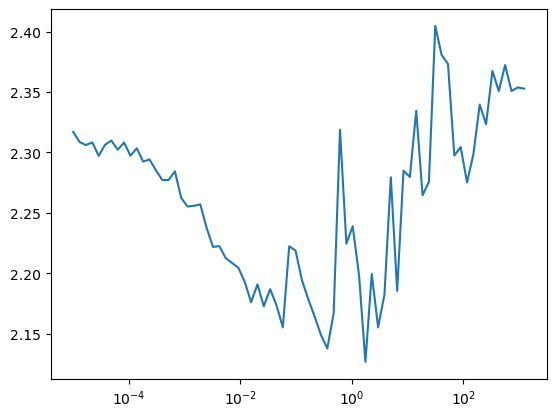

In [23]:
learn.lr_find()

In [24]:
learn.summary()

Total params: 4907598 - Mflops: 33.0


|Module|Input|Output|Num params|MFlops|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3673600|14.7|
|GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5130|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|
|Softmax|(1024, 10)|(1024, 10)|0|0.0|


accuracy,loss,epoch,train
0.817,1.817,0,train
0.870,1.668,0,eval
0.885,1.652,1,train
0.869,1.628,1,eval
0.901,1.594,2,train
0.891,1.598,2,eval
0.920,1.564,3,train
0.911,1.569,3,eval
0.936,1.545,4,train
0.920,1.560,4,eval


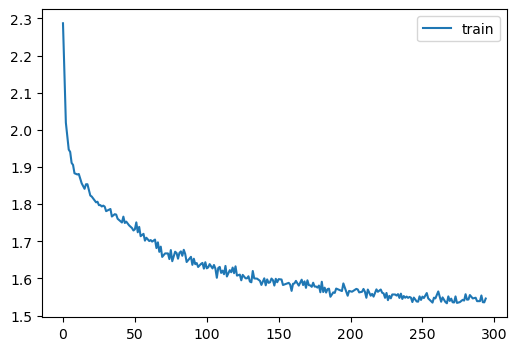

In [27]:
learn.fit(epochs, lr=6e-2, cbs=cbs)

In [13]:
def get_model3(act=partial(GeneralReLU, leak=0.1, sub=0.4), nfs=(16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]    
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]    
    return nn.Sequential(*layers)


In [14]:
learn = Learner(get_model3(act_gr).apply(iw), dls, F.cross_entropy, lr=lr, 
                cbs=lr_find_cbs,
                opt_func=optim.AdamW)

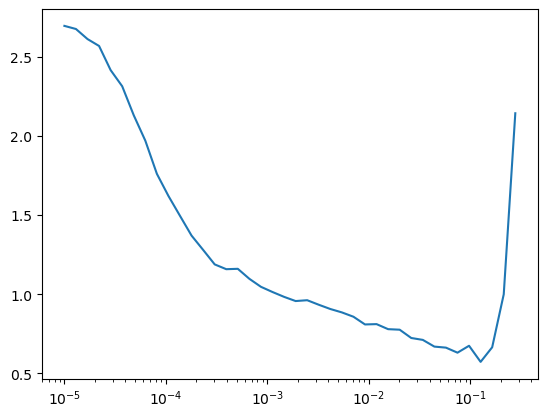

In [22]:
learn.lr_find()

In [114]:
learn.summary()

Total params: 1231428 - Mflops: 18.3


|Module|Input|Output|Num params|MFlops|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.808,0.766,0,train
0.866,0.470,0,eval
0.897,0.394,1,train
0.890,0.350,1,eval
0.921,0.270,2,train
0.914,0.293,2,eval
0.942,0.200,3,train
0.921,0.250,3,eval
0.962,0.147,4,train
0.929,0.233,4,eval


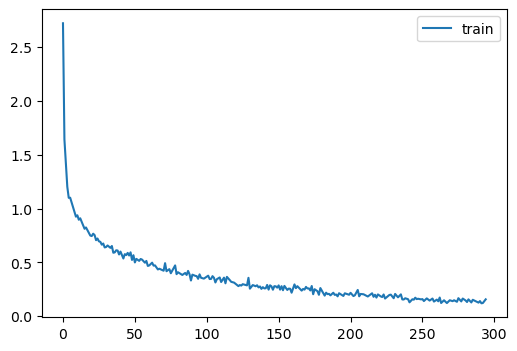

In [24]:
learn.fit(epochs, lr=8e-2, cbs=cbs)

In [15]:
[o.shape for o in get_model3()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 16, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 1, 1, 1]),
 torch.Size([16])]

In [84]:
def get_model4(act=nn.ReLU, nfs=(16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [conv(1, 16, ks=5, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [85]:
[o.shape for o in get_model4()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16])]

In [90]:
learn = Learner(get_model4(act_gr).apply(iw), dls, F.cross_entropy, cbs=lr_find_cbs, opt_func=optim.AdamW)

In [87]:
learn.summary()

Total params: 1224948 - Mflops: 2.8


|Module|Input|Output|Num params|MFlops|
|--|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 16, 10, 10)|448|0.0|
|ResBlock|(1024, 16, 10, 10)|(1024, 32, 5, 5)|14560|0.4|
|ResBlock|(1024, 32, 5, 5)|(1024, 64, 3, 3)|57792|0.5|
|ResBlock|(1024, 64, 3, 3)|(1024, 128, 2, 2)|230272|0.9|
|ResBlock|(1024, 128, 2, 2)|(1024, 256, 1, 1)|919296|0.9|
|GlobalAvgPool|(1024, 256, 1, 1)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


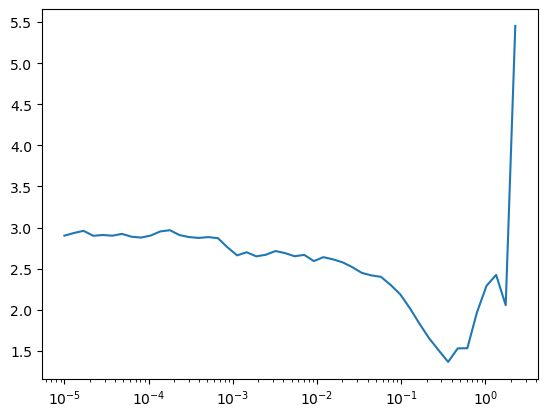

In [88]:
learn.lr_find()

accuracy,loss,epoch,train
0.793,0.790,0,train
0.848,0.503,0,eval
0.881,0.425,1,train
0.875,0.400,1,eval
0.900,0.318,2,train
0.888,0.340,2,eval
0.923,0.243,3,train
0.902,0.297,3,eval
0.944,0.188,4,train
0.907,0.290,4,eval


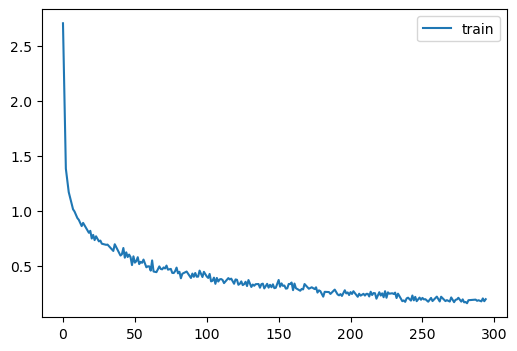

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11fca7be0>
Traceback (most recent call last):
  File "/Users/leonardourbina/mambaforge/envs/fastai/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/Users/leonardourbina/mambaforge/envs/fastai/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/Users/leonardourbina/mambaforge/envs/fastai/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11fca7be0>
Traceback (most recent call last):
  File "/Users/leonardourbina/mambaforge/envs/fastai/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/Users/

In [91]:
learn.fit(epochs, lr=2e-1, cbs=cbs)

# Data augmentation

In [3]:
import nbdev; nbdev.nbdev_export() 